<a href="https://colab.research.google.com/github/nicolasmontano/datasciencecoursera/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from itertools import product #unique combinations
sns.set_style('darkgrid')
plt.style.use('ggplot')
pd.options.display.max_columns = None
pd.options.display.max_rows=200

In [0]:
#Read files
path='/content/drive/My Drive/kaggle/Data/'
#train
train=pd.read_csv(path+'sales_train.csv')
train['date']=pd.to_datetime(train['date'],format='%d.%m.%Y')
#train.set_index('date',inplace=True)
#train['revenue']=sales_train['item_cnt_day']*sales_train['item_price']
#test
test=pd.read_csv(path+'test.csv')
test.drop('ID',axis=1,inplace=True)
test=pd.concat([pd.DataFrame(np.ones(test.shape[0]).astype(int)*34),test],axis=1)
test.rename(columns={0:'date_block_num'},inplace=True)

item_categories=pd.read_csv(path+'item_categories.csv')
items=pd.read_csv(path+'items.csv')
shops=pd.read_csv(path+'shops.csv')

In [0]:
#CREATE MATRIX OF SHOPS:
for i in range(34):
  if i==0:
    matrix=pd.DataFrame(list(product([i],shops['shop_id'].unique(),items['item_id'].unique())))
  else:
    matrix=pd.concat([matrix,pd.DataFrame(list(product([i],shops['shop_id'].unique(),items['item_id'].unique())))],axis=0)

matrix.columns=['date_block_num','shop_id','item_id']

#JOIN TEST
matrix=pd.concat([matrix,test],axis=0,ignore_index=True)
matrix['date_block_num'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34])

In [0]:
grouped=train.groupby(['date_block_num','shop_id','item_id'])['item_cnt_day'].agg({'no':'sum'}).reset_index()
grouped_price=train.groupby(['date_block_num','shop_id','item_id'])['item_price'].agg({'mean_price':'median'}).reset_index()
print(grouped.shape[0])
grouped=grouped.merge(items.loc[:,['item_id','item_category_id']],how='left',on='item_id')
print(grouped.shape[0])
grouped=grouped.merge(grouped_price,how='left',on=['date_block_num','shop_id','item_id'])
print(grouped.shape[0])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  


1609124
1609124
1609124


In [0]:
#FEATURE ENGINEERING
'''
1. Lags
'''
def create_lag(df,n_cols,n_lag):    
    for col in  n_cols:
      for lag in n_lag:
          db1=df.copy()
          db1= db1[['date_block_num','shop_id','item_id',col]] 
          db1['date_block_num']+=lag
          db1.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(lag)]
          df = pd.merge(df, db1, on=['date_block_num','shop_id','item_id'], how='left')
    df=df.fillna(0)
    return df

def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df




In [0]:
grouped=create_lag(grouped,['no','mean_price'],[1,3,6])

In [0]:
matrix = pd.merge(matrix, grouped, on=['date_block_num','shop_id','item_id'], how='left')
matrix.fillna(0,inplace=True)
matrix=downcast_dtypes(matrix)

In [0]:
#Xgboog
#matrix[:100]
matrix=matrix[(matrix['date_block_num']>=6)]
Y_train,X_train= matrix[(matrix['date_block_num']<33)].loc[:,'no'],matrix[(matrix['date_block_num']<33)].drop(['no','mean_price'],axis=1)
Y_valid,X_valid= matrix[(matrix['date_block_num']<32)].loc[:,'no'],matrix[(matrix['date_block_num']<32)].drop(['no','mean_price'],axis=1)
X_test=matrix[(matrix['date_block_num']==34)].drop(['no','mean_price'],axis=1)
del  matrix,train, test, shops, grouped, grouped_price

In [0]:
'''
import xgboost as 

from xgboost import plot_importance

m1=XGBRegressor(max_depth=8,n_estimators=1000,min_child_weight=300    , colsample_bytree=0.8, subsample=0.8, eta=0.25,seed=42)
#xgb=XGBRegressor(max_depth=9,n_estimators=1000,verbosity=1,seed=123)
m1.fit(X_train,Y_train)
'''

'\nimport xgboost as \n\nfrom xgboost import plot_importance\n\nm1=XGBRegressor(max_depth=8,n_estimators=1000,min_child_weight=300    , colsample_bytree=0.8, subsample=0.8, eta=0.25,seed=42)\n#xgb=XGBRegressor(max_depth=9,n_estimators=1000,verbosity=1,seed=123)\nm1.fit(X_train,Y_train)\n'

In [0]:

#pred=xgb.prediction(X_valid)

In [0]:
import xgboost as xgb
data_dmatrix = xgb.DMatrix(data=X_train,label=Y_train)
del X_train, Y_train
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,'max_depth': 5, 'alpha': 10}
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=2,num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[05:10:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:10:49] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[05:11:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:11:06] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


In [0]:
'''
xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()
'''

"\nxgb.plot_tree(xg_reg,num_trees=0)\nplt.rcParams['figure.figsize'] = [50, 10]\nplt.show()\n"

In [0]:
print((cv_results["test-rmse-mean"]).tail(1))

49    1.381572
Name: test-rmse-mean, dtype: float64


In [0]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

[05:30:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:30:04] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


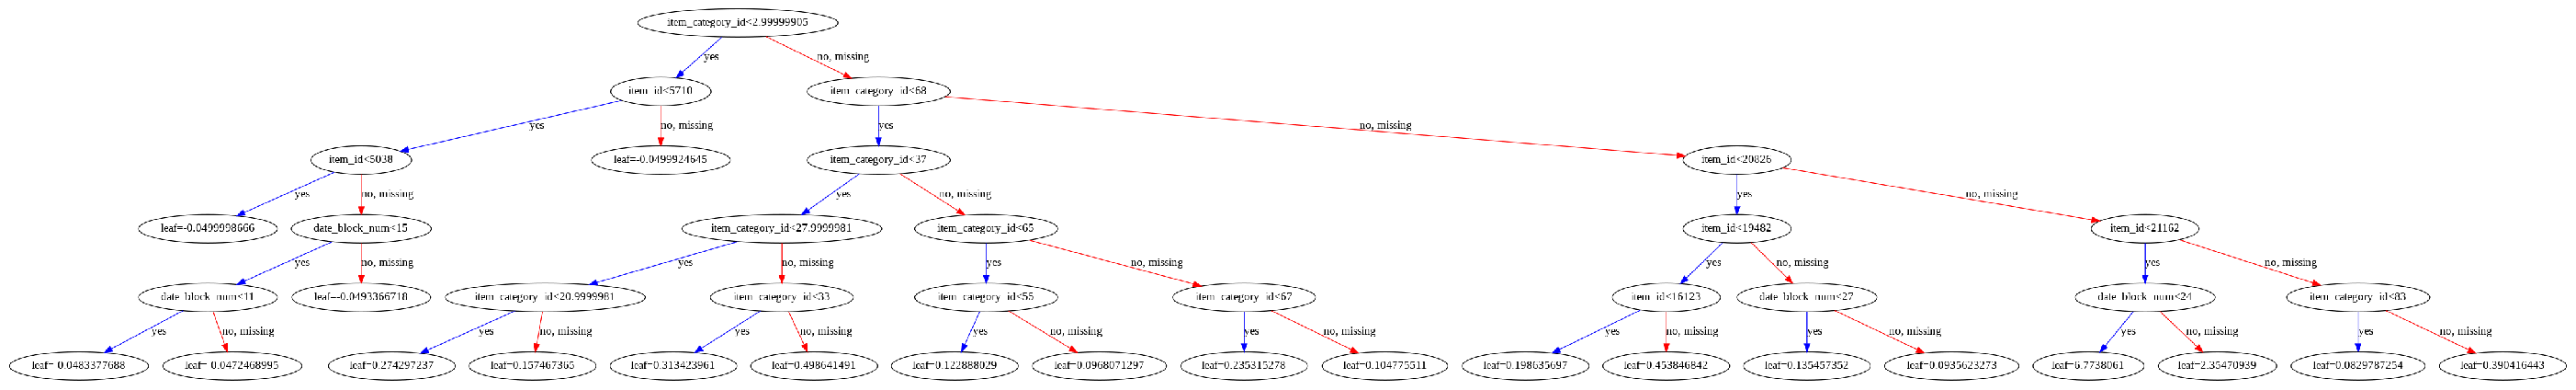

In [0]:

xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [100, 10]
plt.show()

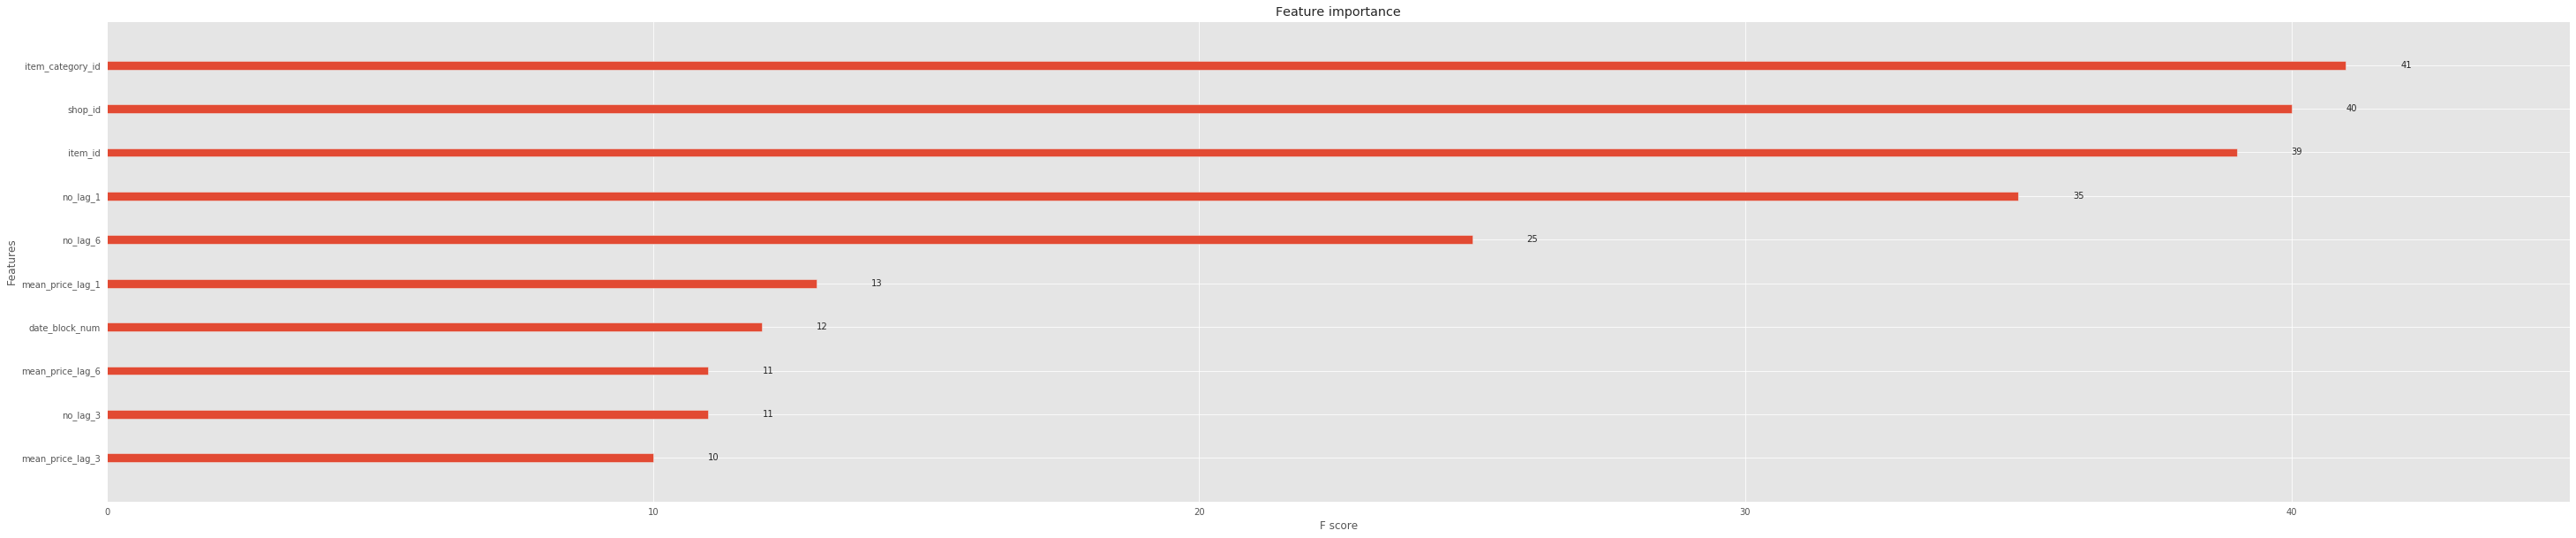

In [0]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [0]:
pred=pd.DataFrame(xg_reg.predict(xgb.DMatrix(X_test))).rename(columns={0:'pred'})

In [0]:
X_test2=pd.concat([X_test,pred],axis=1).reset_index()

In [0]:
X_test2=X_test2.loc[:,['level_0','pred']].rename(columns={'level_0':'ID','pred':'item_cnt_month'})

In [0]:
X_test2.to_csv('/content/drive/My Drive/kaggle/Data/submission.csv',index=False)